<h1><strong>Introduction</strong></h1>
This is an implementation of Arificial Neural Network(ANN). For data preprocessing, I have used sklearn and for data generation, numpy. Inspired by <strong>Keras</strong> I've written the class to resemble the brilliant framework as closely as possible.

In [92]:
import numpy as np 
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder,MinMaxScaler
np.random.seed(0)
# Any results you write to the current directory are saved as output.

<h1><strong>Generating data</strong><h1>(possibly linearly separable)

In [93]:
x1c1=np.random.random((1000,1))
x2c1=-5*x1c1+3+(np.random.randint(3,size=(1000,1)))*np.random.random((1000,1))+1
y1=np.ones((1000,1))
x1c2=np.random.random((1000,1))
x2c2=-5*x1c2+3-(np.random.randint(3,size=(1000,1)))*np.random.random((1000,1))-1
y2=np.zeros((1000,1))
df1=np.concatenate((x1c1,x2c1),axis=1)
df2=np.concatenate((x1c2,x2c2),axis=1)
df1=np.concatenate((df1,df2),axis=0)
y1=np.concatenate((y1,y2),axis=0)
df1=np.concatenate((df1,y1),axis=1)
np.random.shuffle(df1)
y1=df1[:,2].flatten().astype(int)
print(y1)
y1=np.eye(2)[y1]
df1=df1[:,:2]
print(df1)
trainX=df1
trainY=y1

[0 0 0 ..., 1 1 1]
[[ 0.90496764 -3.34226272]
 [ 0.25360738  0.7319631 ]
 [ 0.65113585 -1.47340395]
 ..., 
 [ 0.66250457  0.68747714]
 [ 0.99884701 -0.99423503]
 [ 0.78323444  0.49600897]]


To load the ring dataset, un-comment this one and run

In [94]:
'''train_set=np.loadtxt("ring_test.txt")
enc=LabelEncoder()
y=enc.fit_transform(train_set[:,2])
train_set[:,2]=y
trainX=train_set[:,0:2]
trainY=np.eye(2)[train_set[:,2].astype(int)]'''

'train_set=np.loadtxt("ring_test.txt")\nenc=LabelEncoder()\ny=enc.fit_transform(train_set[:,2])\ntrain_set[:,2]=y\ntrainX=train_set[:,0:2]\ntrainY=np.eye(2)[train_set[:,2].astype(int)]'

In [95]:
trainY.shape

(2000, 2)

<h1><strong>Making the splits</strong></h1>
Splitting the dataset into train,test and validation sets

In [96]:
trainX,testX,trainY,testY=train_test_split(trainX,trainY,test_size=0.3,stratify=trainY,random_state=2)
testX,valX,testY,valY=train_test_split(testX,testY,test_size=0.33,stratify=testY,random_state=2)

In [97]:
print(trainX.shape,trainY.shape)
print(valX.shape,valY.shape)
print(testX.shape,testY.shape)

(1400, 2) (1400, 2)
(198, 2) (198, 2)
(402, 2) (402, 2)


In [98]:
np.argmax(valY,axis=1).sum()

99

<h1><strong>Lets Plot</strong><h1>

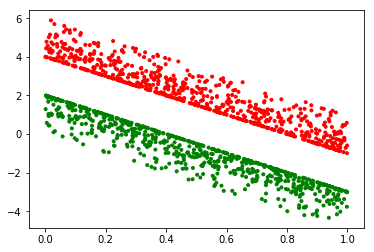

In [99]:
label=np.argmax(trainY,axis=1)
colors=["green","red"]
plt.scatter(trainX[:,0], trainX[:,1], c=label, cmap=matplotlib.colors.ListedColormap(colors),marker='.')

In [100]:
#utility sigmoid activation function
def sigmoid(x):
    return 1/(1+np.exp(-x))

<h1><strong>The actual Model class for ANN </strong></h1>

In [101]:
#the actual class that gives the model
class Model:
    def __init__(self):
        self.layer_count=0
        self.weights={}
        self.biases={}
        self.l_dims=[]
        self.grad_W={}
        self.grad_b={}
        self.layer_ops={} #stores the output of each layer.
        self.summary={} #stores the name and shape of each layer
        self.history={"train_loss":[],"val_loss":[],"train_acc":[],"val_acc":[]}
        self.best=None
    
    #returns the layer parameters
    def Dense(self,nodes=1,input_shape=None):
        self.layer_count+=1
        if input_shape:
            self.l_dims.append(input_shape)
        self.l_dims.append(nodes)
        return np.random.random_sample((nodes,self.l_dims[self.layer_count-1])),np.random.random_sample((nodes,1))
        
    #adds the weights passed as layers
    def add(self,weights):
        self.weights[f"w_{self.layer_count}"]=weights[0]
        self.biases[f"b_{self.layer_count}"]=weights[1]
        self.summary[f"Dense_{self.layer_count}"]=weights[0].shape
        
    def predict(self,x):
        self.layer_ops["v_0"]=x
        for i in range(self.layer_count):
            x=self.layer_ops[f"v_{i}"]
            x=np.dot(x,self.weights[f'w_{i+1}'].T)
            x=sigmoid(x)
            self.layer_ops[f'v_{i+1}']=np.add(x,self.biases[f"b_{i+1}"].T) #saving the layer output
        return x
    
    def fit(self,X,Y,validation_data=None,epochs=100000,batch_size=10,lr=0.005):
        batches=X.shape[0]//batch_size
        best_acc=0
        if validation_data:
            valX,valY=validation_data
        for e in range(epochs):
            loss=0
            for i in range(batches):
                x=X[i*batch_size:i+1*batch_size]
                y=Y[i*batch_size:i+1*batch_size]
                v=self.predict(x)
                grad_base=((v-y)*(1-v)*v).T #the centerpiece of the gardient for every layer
                for j in reversed(range(1,self.layer_count+1)):
                    self.grad_W[f'{"w_"}{j}']=grad_base
                    #calculation of gradient for each layer
                    for k in reversed(range(j,self.layer_count)):
                        self.grad_W[f'{"w_"}{j}']=np.dot(self.weights[f'{"w_"}{k+1}'].T,self.grad_W[f'{"w_"}{j}'])
                        self.grad_W[f'{"w_"}{j}']=self.grad_W[f'{"w_"}{j}']*(self.layer_ops[f'{"v_"}{k}']*
                                                                             (1-self.layer_ops[f'{"v_"}{k}'])).T
                    self.grad_b[f"b_{j}"]=np.sum(self.grad_W[f"w_{j}"],axis=1).reshape(self.biases[f"b_{j}"].shape) #bias gradient
                    self.grad_W[f'{"w_"}{j}']=np.dot(self.grad_W[f'{"w_"}{j}'],self.layer_ops[f'{"v_"}{j-1}']) #weight gradient
                    #bias and weights adjustment
                    self.weights[f'{"w_"}{j}']-=lr*self.grad_W[f'{"w_"}{j}']
                    self.biases[f'b_{j}']-=lr*self.grad_b[f"b_{j}"]
                    #self.weights[f'{"w_"}{j}']/=trainX.shape[0]
                    #self.biases[f'{"b_"}{j}']/=trainX.shape[0]
                loss+=np.sum((v-y)*(v-y))/(2*batch_size) #batch loss aggregation
            val_loss=0
            train_acc=accuracy_score(np.argmax(trainY,axis=1),np.argmax(self.predict(trainX),axis=1))
            #saving performance on train set
            self.history["train_acc"].append(train_acc)
            self.history["train_loss"].append(loss)
            label=self.predict(trainX)
            #validation
            if validation_data:
                val_v=self.predict(valX)
                #print(val_v.shape,valY.shape)
                val_loss+=np.sum((val_v-valY)*(val_v-valY))/(2*valX.shape[0])
                val_acc=accuracy_score(np.argmax(valY,axis=1),np.argmax(self.predict(valX),axis=1))
                self.history["val_acc"].append(val_acc)
                self.history["val_loss"].append(val_loss)
                if best_acc<val_acc:
                    self.best=Model()
                    for key,value in self.weights.items():
                        self.best.weights[key]=np.copy(value)
                    for key,value in self.biases.items():
                        self.best.biases[key]=np.copy(value)
                    best_acc=val_acc
                print(f"epoch {e}  train loss: {loss}  validation loss:{val_loss}")
            else:
                print(f"epoch {e}  train loss: {loss} ")

<h1><strong> Creation and fitting of the model </strong></h1>

Works fine for one layer. Learns but underfits.

In [102]:
model=Model()
model.add(model.Dense(nodes=4,input_shape=trainX.shape[1]))
model.add(model.Dense(nodes=3))
model.add(model.Dense(trainY.shape[1]))
model.fit(trainX,trainY,validation_data=[valX,valY],epochs=2500,batch_size=50,lr=0.01)

epoch 0  train loss: 0.37381618071985423  validation loss:0.35488674791124963
epoch 1  train loss: 0.36747623112286587  validation loss:0.348251400667768
epoch 2  train loss: 0.3609876977575595  validation loss:0.3415144485133681
epoch 3  train loss: 0.3543691899191606  validation loss:0.33469242347090694
epoch 4  train loss: 0.3476230134347044  validation loss:0.327786123035066
epoch 5  train loss: 0.3407346211022919  validation loss:0.32078500688107725
epoch 6  train loss: 0.33367812904385813  validation loss:0.313678108277355
epoch 7  train loss: 0.32642857333170844  validation loss:0.3064706008689808
epoch 8  train loss: 0.318980018340055  validation loss:0.2992031535859555
epoch 9  train loss: 0.31136664982863715  validation loss:0.2919687297900416
epoch 10  train loss: 0.30368143769106903  validation loss:0.28491907562526325
epoch 11  train loss: 0.29608430965928645  validation loss:0.27825287731393555
epoch 12  train loss: 0.2887911760210461  validation loss:0.272182581109563
ep

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until


epoch 628  train loss: 0.17771718543318551  validation loss:0.16521068519718882
epoch 629  train loss: 0.1776651578803776  validation loss:0.1651703544637242
epoch 630  train loss: 0.17761365509564164  validation loss:0.16513048801305694
epoch 631  train loss: 0.177562673254294  validation loss:0.16509108138491124
epoch 632  train loss: 0.17751220846984342  validation loss:0.1650521300471847
epoch 633  train loss: 0.17746225679661115  validation loss:0.1650136293990252
epoch 634  train loss: 0.1774128142323741  validation loss:0.16497557477396452
epoch 635  train loss: 0.1773638767210284  validation loss:0.16493796144310452
epoch 636  train loss: 0.1773154401552718  validation loss:0.16490078461835223
epoch 637  train loss: 0.17726750037930283  validation loss:0.16486403945570138
epoch 638  train loss: 0.17722005319153347  validation loss:0.16482772105855673
epoch 639  train loss: 0.17717309434731512  validation loss:0.16479182448109822
epoch 640  train loss: 0.17712661956167203  valid

<h1><strong>Visualization of the Model History</strong></h1>

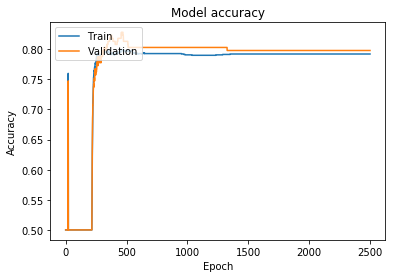

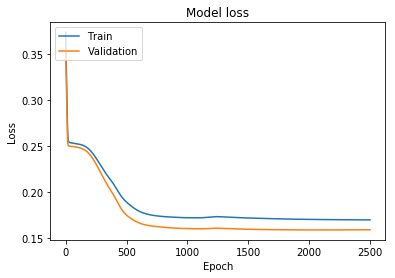

In [103]:
plt.plot(model.history['train_acc'])
plt.plot(model.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values/

plt.plot(model.history['train_loss'])
plt.plot(model.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

<h1><strong>Testing it out</strong></h1>

In [104]:
accuracy_score(np.argmax(valY,axis=1),np.argmax(model.predict(valX),axis=1))

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until


0.79797979797979801

Testing against sklearn.LogisticRegression

In [105]:
from sklearn.linear_model import LogisticRegression
x=trainX
y=np.argmax(trainY,axis=1)
reg=LogisticRegression().fit(x,y)
test_preds=np.round(reg.predict(testX))
testy=np.argmax(testY,axis=1)
acc=accuracy_score(testy,test_preds)
print("sklearn accuracy: ",acc)

sklearn accuracy:  1.0


C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until


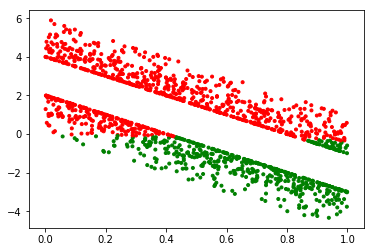

In [106]:
label=np.argmax(model.predict(trainX),axis=1)
colors=["green","red"]
plt.scatter(trainX[:,0], trainX[:,1], c=label, cmap=matplotlib.colors.ListedColormap(colors),marker='.')

In [ ]:
Decision Boundary Visualization

In [107]:
x1c1=np.random.random((2000,1))
x2c1=-5*x1c1+3+(np.random.randint(100,size=(2000,1)))*np.random.random((2000,1))
y1=np.ones((2000,1))
x1c2=np.random.random((2000,1))
x2c2=-5*x1c2+3-(np.random.randint(100,size=(2000,1)))*np.random.random((2000,1))
y2=np.zeros((2000,1))
bdf1=np.concatenate((x1c1,x2c1),axis=1)
bdf2=np.concatenate((x1c2,x2c2),axis=1)
bdf1=np.concatenate((bdf1,bdf2),axis=0)
y1=np.concatenate((y1,y2),axis=0)
bdf1=np.concatenate((bdf1,y1),axis=1)
np.random.shuffle(bdf1)
y1=bdf1[:,2].flatten().astype(int)
print(y1)
y1=np.eye(2)[y1]
bdf1=bdf1[:,:2]
print(bdf1)
bX=bdf1
bY=y1

[0 0 1 ..., 1 1 1]
[[  3.62316389e-01  -5.40157531e+00]
 [  3.58369101e-01  -6.81036978e+01]
 [  3.26047993e-01   5.04831085e+01]
 ..., 
 [  4.48691931e-01   1.35067869e+00]
 [  4.03553267e-02   4.12255376e+01]
 [  5.12644614e-01   2.67556487e+01]]


C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until


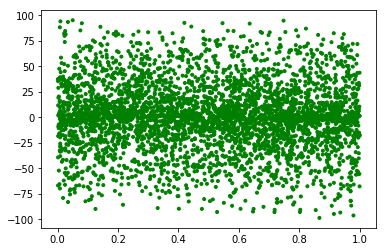

In [62]:
label=np.argmax(model.predict(bX),axis=1)
colors=["green","red"]
plt.scatter(bX[:,0], bX[:,1], c=label, cmap=matplotlib.colors.ListedColormap(colors),marker='.')